In [26]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from env.area import Area

# Set seaborn theme globally
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)


def plot_histograms(projects, area_pickle_file):
    contributors_per_project(projects)
    success_rate_over_time(projects)
    quality_metrics_over_time(projects)
    collab_metrics_over_time(projects)
    projects_per_contributor(projects)
    # prestige_per_project(projects)
    completion_per_project(projects)
    quality_per_project(projects)
    topic_area_per_project(projects, area_pickle_file)

def societal_value_over_time(projects):
    # Convert to DataFrame
    df = pd.DataFrame(projects)

    # Sort by time
    df = df.sort_values("start_time")[df.start_time>100]

    # Compute cumulative sum and cumulative mean
    df["cumulative_societal_value"] = df["societal_value_score"].cumsum()
    df["cumulative_mean"] = df["cumulative_societal_value"] / (df.index + 1)

    # ==== Plot cumulative mean ====
    plt.figure(figsize=(8,6))
    plt.plot(df["start_time"], df["cumulative_mean"], linestyle="-", color="blue")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Mean Societal Value")
    plt.title("Cumulative Mean Societal Value Over Time")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def societal_value_per_archetype(agents, projects):
    # ==== Build agent → archetype map ====
    agent_archetype = {}
    for a in agents:
        for k, v in a.items():
            idx = int(k.split('_')[1])   # extract numeric ID
            if v is not None:
                agent_archetype[idx] = v['archetype']
    # ==== Collect societal values per archetype ====
    records = []
    for p in projects:
        for contributor in p['contributors']:
            if contributor in agent_archetype:
                records.append({
                    'archetype': agent_archetype[contributor],
                    'societal_value': p['societal_value_score']
                })

    df = pd.DataFrame(records)
    print(df.archetype.unique())
    # ==== Compute mean and error ====
    grouped = df.groupby("archetype")["societal_value"]
    means = grouped.mean()
    errors = grouped.std() / np.sqrt(grouped.count())  # Standard error of the mean
    print(grouped)
    # ==== Plot ====
    plt.figure(figsize=(8,6))
    means.plot(
        kind="bar",
        yerr=errors,
        capsize=5,
        color="skyblue",
        edgecolor="black"
    )
    plt.ylabel("Mean Societal Value (±SEM)")
    plt.title("Mean Societal Value per Archetype")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def contributors_per_project(projects):
    num_contributors = [len(p["contributors"]) for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(num_contributors, bins=range(1, max(num_contributors) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Contributors")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Contributors per Project")
    plt.tight_layout()
    plt.show()


def projects_per_contributor(projects):
    all_contributors = []
    for p in projects:
        all_contributors.extend(p["contributors"])

    author_counts = Counter(all_contributors)
    papers_per_author = list(author_counts.values())

    plt.figure(figsize=(8, 5))
    sns.histplot(papers_per_author, bins=range(1, max(papers_per_author) + 2), kde=False, discrete=True)
    plt.xlabel("Number of Papers per Author")
    plt.ylabel("Number of Authors")
    plt.title("Authors by Number of Papers")
    plt.tight_layout()
    plt.show()


def prestige_per_project(projects):
    prestige_categories = [int(p["project_id"].split("-")[1]) % 3 for p in projects]

    plt.figure(figsize=(6, 4))
    sns.histplot(prestige_categories, bins=range(1, max(prestige_categories)), kde=False, discrete=True)
    plt.xlabel("Prestige Category (mod 3)")
    plt.ylabel("Number of Projects")
    plt.title("Projects per Prestige Category")
    plt.tight_layout()
    plt.show()


def completion_per_project(projects):
    completion = [max(0, p["current_effort"] / p["required_effort"]) * 100 for p in projects]
    plt.figure(figsize=(8, 5))
    sns.histplot(completion, bins=range(0, 110, 10), kde=False, discrete=True)
    plt.xlabel("Completion (%)")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Completion")
    plt.tight_layout()
    plt.show()


def quality_per_project(projects):
    quality_scores = [p["quality_score"] for p in projects]

    plt.figure(figsize=(8, 5))
    sns.histplot(quality_scores, bins=[i/10 for i in range(0, 11)], kde=False)
    plt.xlabel("Quality Score")
    plt.ylabel("Number of Projects")
    plt.title("Distribution of Project Quality Scores")
    plt.tight_layout()
    plt.show()

def success_rate_over_time(projects):
    """
    Plots the cumulative success rate of projects (finished / started)
    over time, using 'start_time' and 'finished' from the projects list.
    """
    # Extract (start_time, finished) for each project
    events = [(p["start_time"], p["finished"], p["final_reward"]) for p in projects]

    # Sort by start time
    events.sort(key=lambda x: x[0])

    time_steps = []
    success_rates = []

    finished = 0
    successful = 0

    for t, is_finished, score in events:
        if is_finished:
            finished += 1
            if score > 0:
                successful += 1
        success_rate = successful/ finished if finished > 0 else 0
        time_steps.append(t)
        success_rates.append(success_rate)

    # Plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=time_steps, y=success_rates)
    plt.xlabel("Time Step")
    plt.ylabel("Success Rate")
    plt.title("Project Success Rate Over Time")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

def quality_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in one line plot.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]:[] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, p in projects_sorted]
    quality = [np.mean([p["quality_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    novelty = [np.mean([p["novelty_score"] for p in pjs]) for _ ,pjs in projects_sorted]
    value = [np.mean([p["societal_value_score"] for p in pjs]) for _, pjs in projects_sorted]

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=times, y=quality, label="Quality Score")
    sns.lineplot(x=times, y=novelty, label="Novelty")
    sns.lineplot(x=times, y=value, label="Societal Value")

    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title("Project Metrics Over Time")
    plt.legend()
    # plt.tight_layout()
    plt.show()

def collab_metrics_over_time(projects):
    """
    Plots quality score, number of citations, current effort,
    and novelty over project start_time in three side-by-side plots.
    """
    # Sort projects by start time
    projects_per_time = {p["start_time"]: [] for p in projects}
    for p in projects:
        projects_per_time[p["start_time"]].append(p)
    projects_sorted = sorted(projects_per_time.items(), key=lambda p: p[0])

    times = [t for t, _ in projects_sorted]
    effort = [np.mean([p["current_effort"] for p in pjs]) for _, pjs in projects_sorted]
    n_contributors = [np.mean([len(p["contributors"]) for p in pjs]) for _, pjs in projects_sorted]
    citations = [np.sum([len(p["citations"]) for p in pjs]) for _, pjs in projects_sorted]

    # Create 1 row, 3 column subplot layout
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

    # Plot effort
    sns.lineplot(x=times, y=effort, ax=axes[0])
    axes[0].set_title("Current Effort")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Effort")

    # Plot contributors
    sns.lineplot(x=times, y=n_contributors, ax=axes[1])
    axes[1].set_title("# Contributors per Paper")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("# Contributors")

    # Plot citations
    sns.lineplot(x=times, y=citations, ax=axes[2])
    axes[2].set_title("Citations")
    axes[2].set_xlabel("Time Step")
    axes[2].set_ylabel("Citations")

    plt.tight_layout()
    plt.show()



def topic_area_per_project(projects, area_pickle_file):
    area = Area.load(area_pickle_file)
    area.visualize(sampled_points=[p["kene"] for p in projects])

def visualize_policy_population_proportion(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their proportions over time as a stacked area chart.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a list of agent dicts
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Normalize to proportions
    proportions = pivot.div(pivot.sum(axis=1), axis=0)

    # Plot stacked area chart
    plt.figure()
    proportions.plot.area(colormap="tab20", alpha=0.85, figsize=(12, 8))

    plt.title("Archetype Proportions Over Simulation Steps")
    plt.xlabel("Step")
    plt.ylabel("Proportion")
    plt.legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

def visualize_policy_population(simulation_steps):
    """
    Given a list of dictionaries representing steps in the simulation,
    count the occurrences of each 'archetype' per step and visualize 
    their absolute counts over time as a line plot.
    Also shows the total number of agents per step in a smaller panel underneath.
    """
    # Collect archetype counts per step
    records = []
    for step_idx, step in enumerate(simulation_steps):
        for agent in step.values():  # assume step is a dict of agents
            if agent is not None:
                records.append({
                    "step": step_idx,
                    "archetype": agent["archetype"]
                })

    df = pd.DataFrame(records)

    # Count archetypes per step
    counts = df.groupby(["step", "archetype"]).size().reset_index(name="count")

    # Pivot to wide format (steps × archetypes)
    pivot = counts.pivot(index="step", columns="archetype", values="count").fillna(0)

    # Compute total per step
    total_counts = pivot.sum(axis=1)

    # Two subplots: main plot + smaller panel underneath
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Top: archetype counts
    pivot.plot.line(ax=axes[0])
    axes[0].set_title("Archetype Counts Over Simulation Steps")
    axes[0].set_ylabel("Count")
    axes[0].legend(title="Archetype", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Bottom: total counts
    total_counts.plot(ax=axes[1], color="black")
    axes[1].set_title("Total Agents")
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Total Count")

    plt.tight_layout()
    plt.show()

In [ ]:
# Load projects list from JSON file
with open("../log/policy_all_careerist_projects.json", "r") as f:
    all_careerist_projects = json.load(f)


In [ ]:
plot_histograms(all_careerist_projects, "../log/policy_all_careerist_area.pickle")

In [ ]:
# Load projects list from JSON file
with open("../log/policy_all_orthodox_projects.json", "r") as f:
    all_orthodox_projects = json.load(f)

In [ ]:
plot_histograms(all_orthodox_projects, "../log/policy_all_orthodox_area.pickle")

In [ ]:

    # Load projects list from JSON file
with open("../log/policy_all_mass_producer_projects.json", "r") as f:
    all_mass_producer_projects = json.load(f)
with open("../log/policy_all_mass_producer_actions.jsonl", "r") as f:
    all_mass_producer_actions = []
    for line in f.readlines():
        all_mass_producer_actions.append(json.loads(line))

In [ ]:
visualize_policy_population_proportion(all_mass_producer_actions)
visualize_policy_population(all_mass_producer_actions)

In [ ]:
plot_histograms(all_mass_producer_projects, "../log/policy_all_mass_producer_area.pickle")

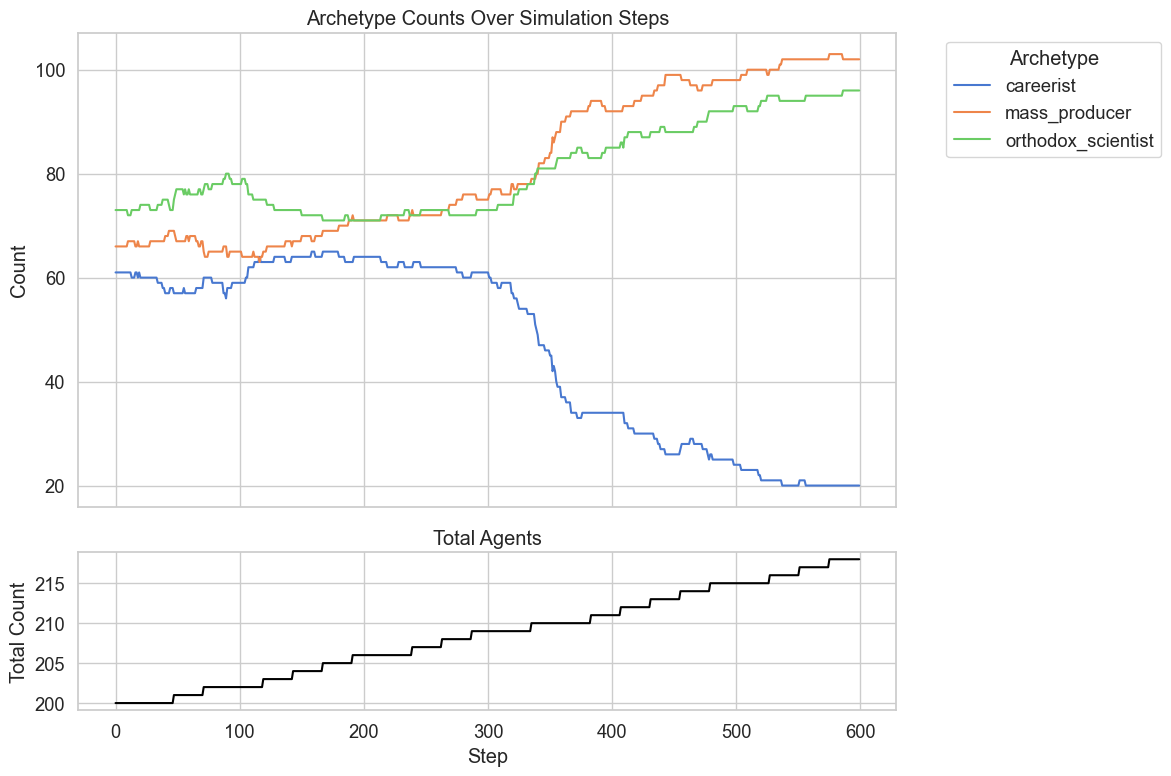

['orthodox_scientist' 'mass_producer']


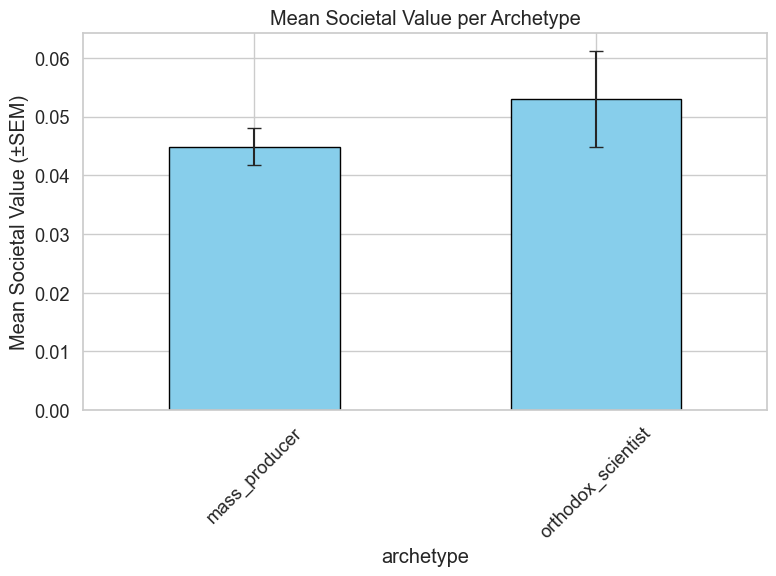

/var/folders/rb/7qjlmv156wgfwfk3rlmzs_q00000gp/T/ipykernel_5984/2948815708.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values("start_time")[df.start_time>100]


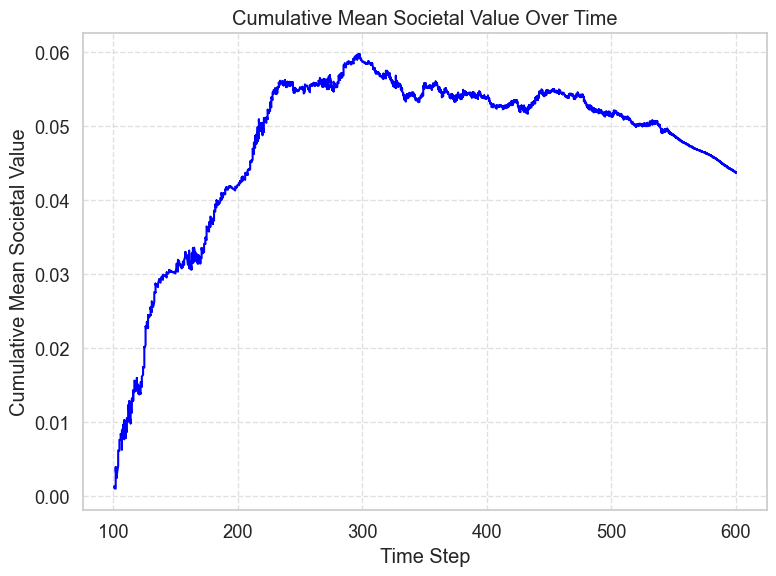

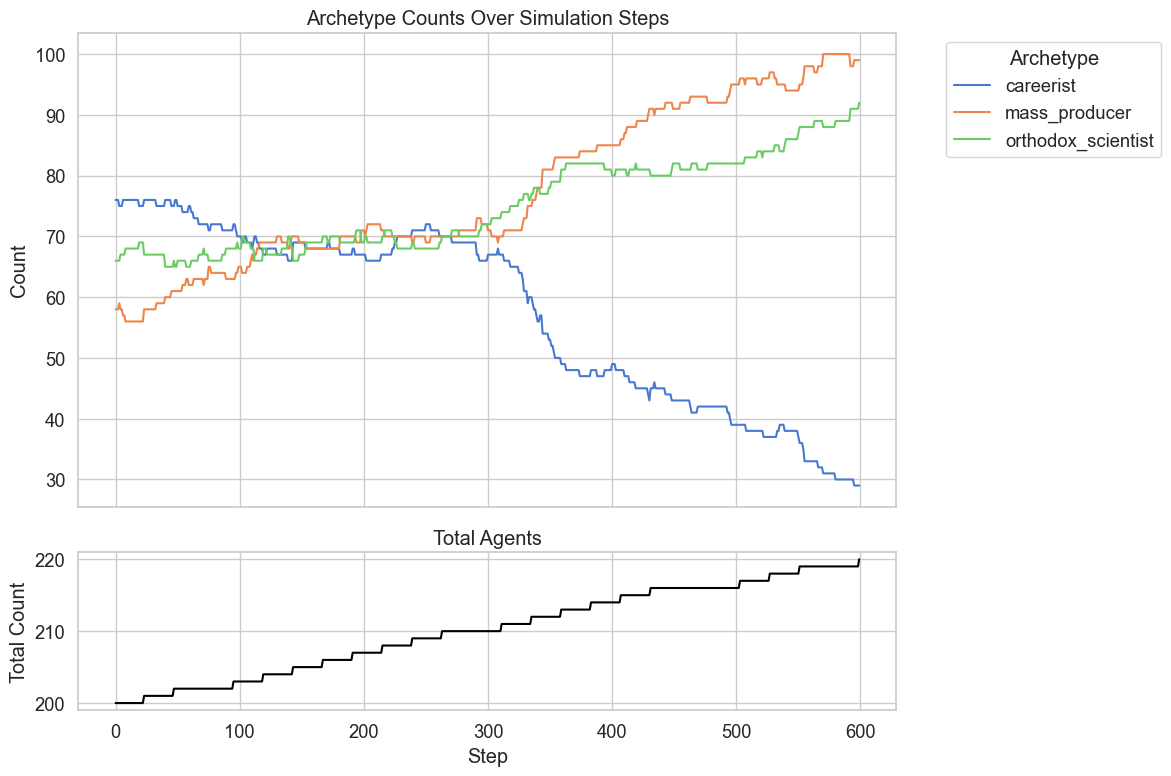

['orthodox_scientist' 'mass_producer']


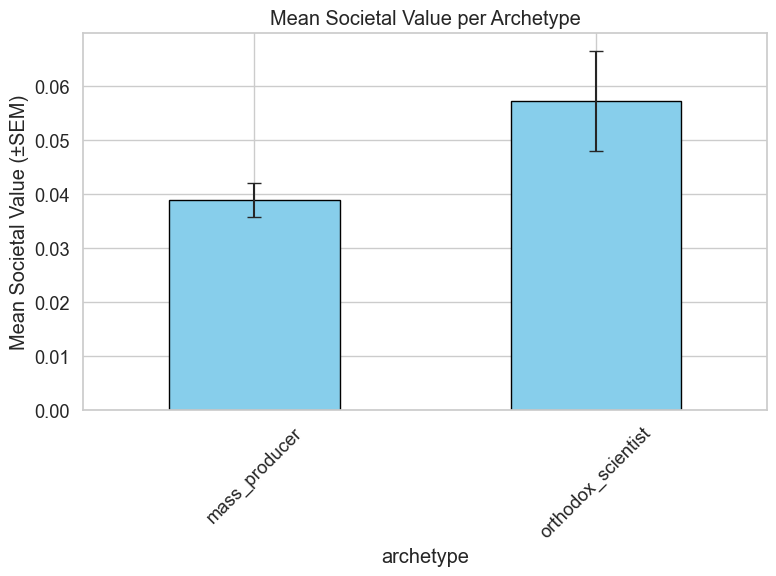

/var/folders/rb/7qjlmv156wgfwfk3rlmzs_q00000gp/T/ipykernel_5984/2948815708.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values("start_time")[df.start_time>100]


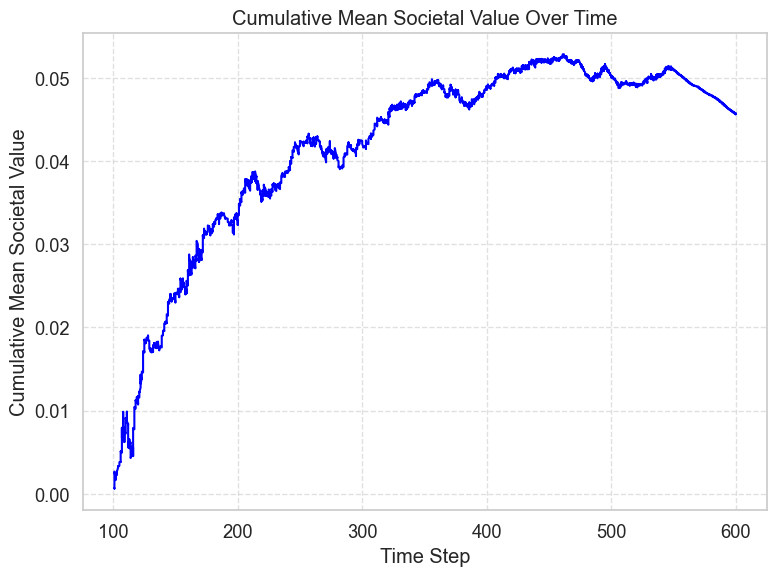

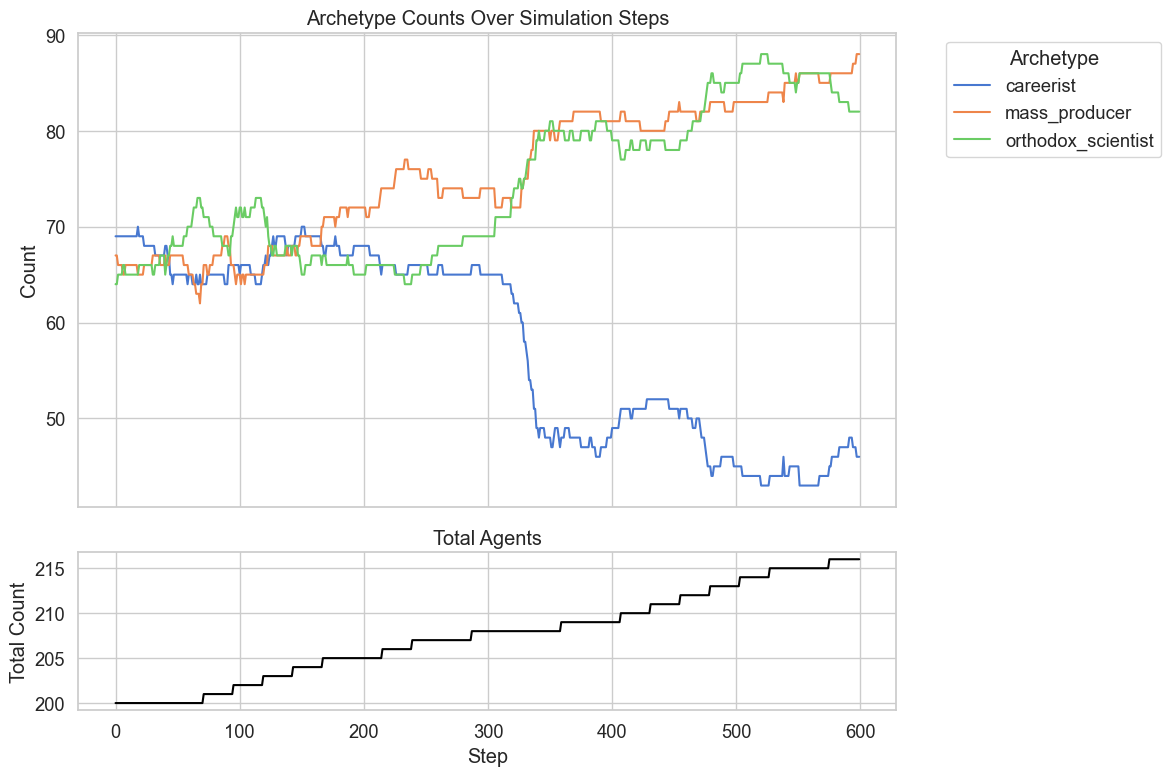

['mass_producer' 'orthodox_scientist']


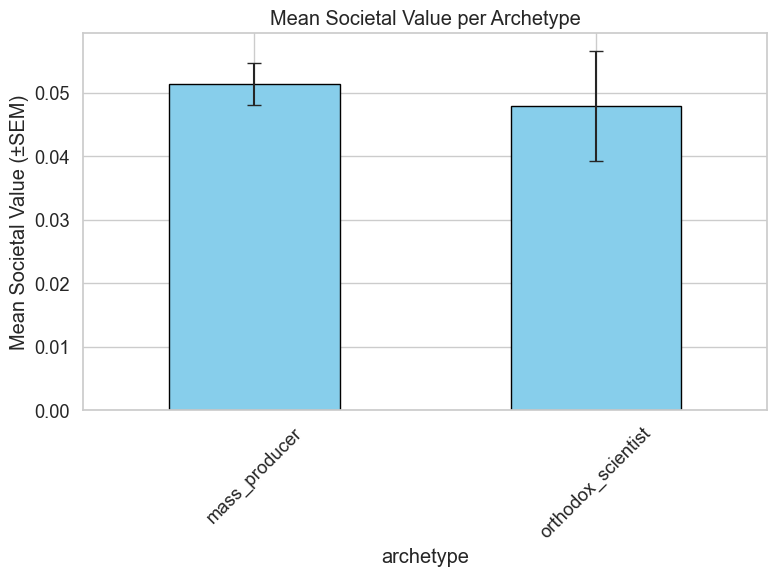

/var/folders/rb/7qjlmv156wgfwfk3rlmzs_q00000gp/T/ipykernel_5984/2948815708.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df.sort_values("start_time")[df.start_time>100]


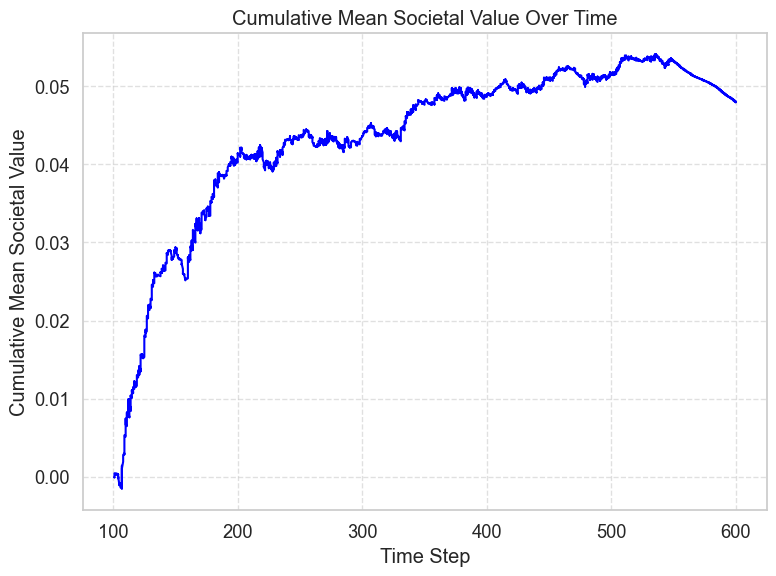

In [31]:

# Load projects list from JSON file
with open("../log/balanced_evenly_projects.json", "r") as f:
    balanced_evenly_projects = json.load(f)
with open("../log/balanced_evenly_actions.jsonl", "r") as f:
    balanced_evenly_actions = []
    for line in f.readlines():
        balanced_evenly_actions.append(json.loads(line))
with open("../log/balanced_multiply_projects.json", "r") as f:
    balanced_multiply_projects = json.load(f)
with open("../log/balanced_multiply_actions.jsonl", "r") as f:
    balanced_multiply_actions = []
    for line in f.readlines():
        balanced_multiply_actions.append(json.loads(line))
with open("../log/balanced_by_effort_projects.json", "r") as f:
    balanced_by_effort_projects = json.load(f)
with open("../log/balanced_by_effort_actions.jsonl", "r") as f:
    balanced_by_effort_actions = []
    for line in f.readlines():
        balanced_by_effort_actions.append(json.loads(line))
# visualize_policy_population_proportion(balanced_actions)
# plot_histograms(balanced_projects, "../log/balanced_area.pickle")
visualize_policy_population(balanced_multiply_actions)
societal_value_per_archetype(balanced_multiply_actions, balanced_multiply_projects)
societal_value_over_time(balanced_multiply_projects)
visualize_policy_population(balanced_evenly_actions)
societal_value_per_archetype(balanced_evenly_actions, balanced_evenly_projects)
societal_value_over_time(balanced_evenly_projects)
visualize_policy_population(balanced_by_effort_actions)
societal_value_per_archetype(balanced_by_effort_actions, balanced_by_effort_projects)
societal_value_over_time(balanced_by_effort_projects)

<Figure size 640x480 with 0 Axes>

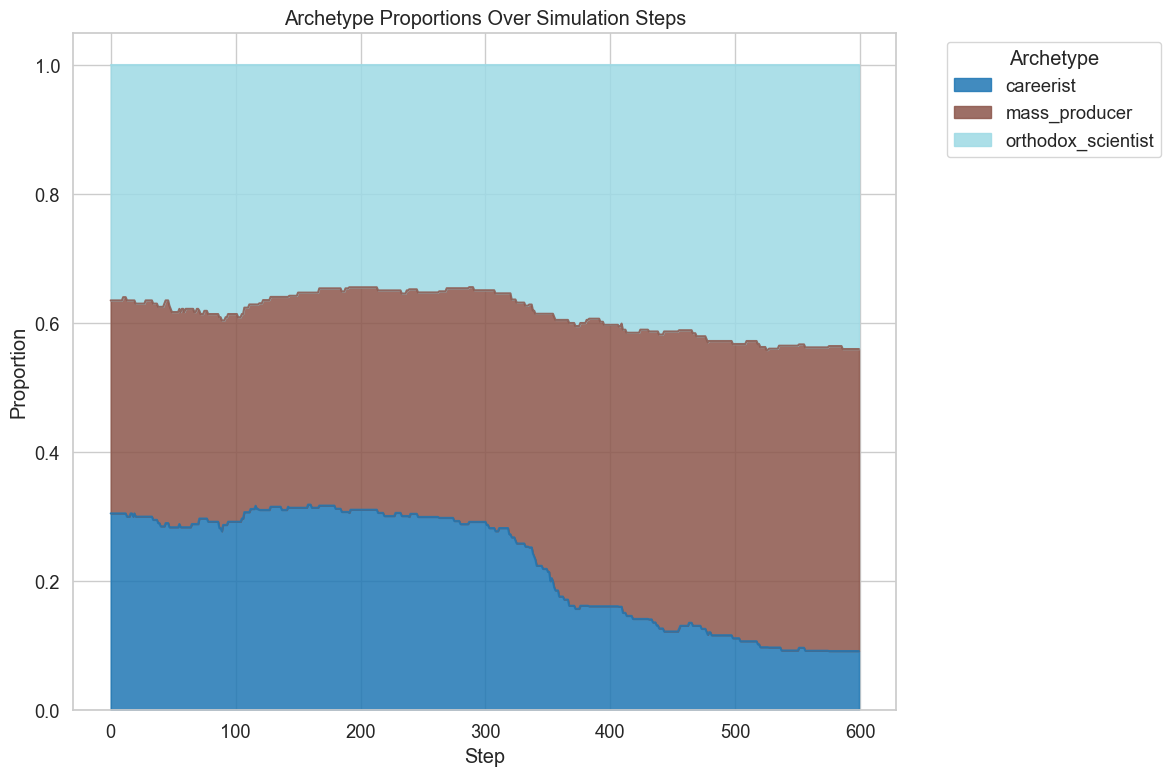

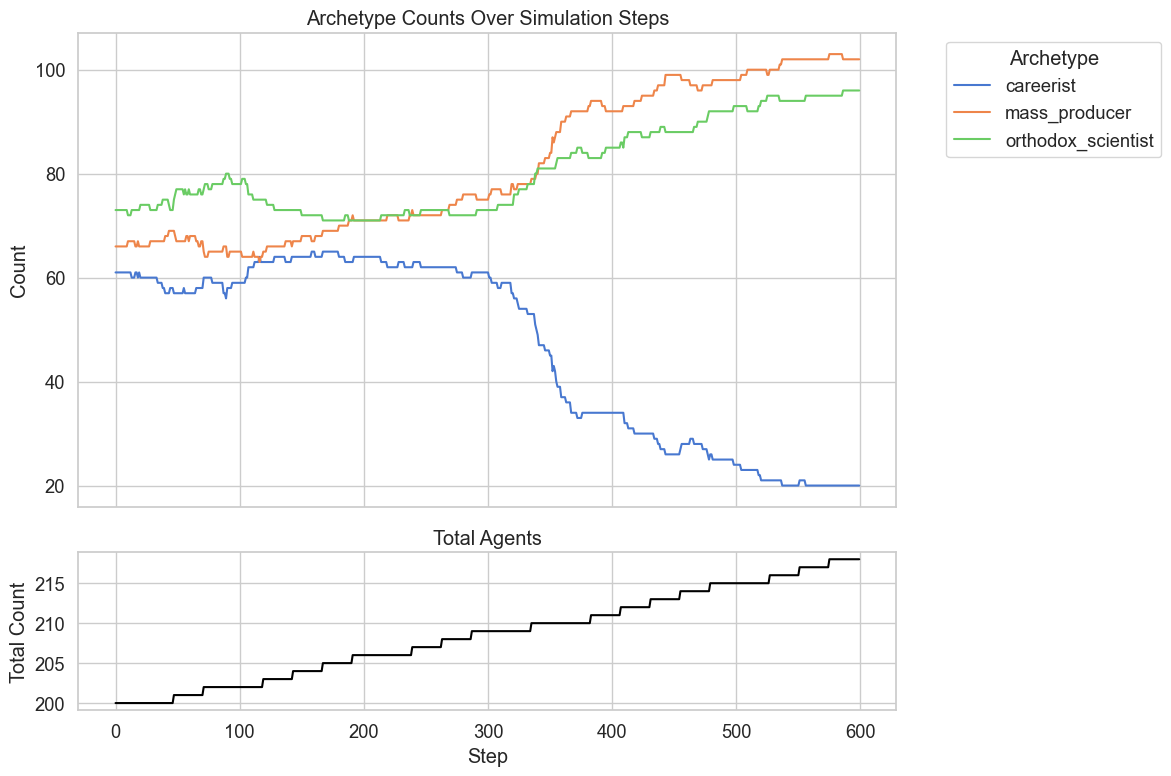

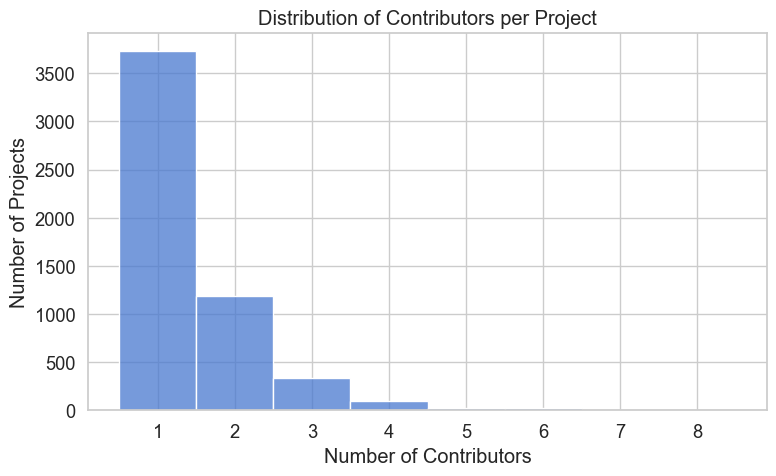

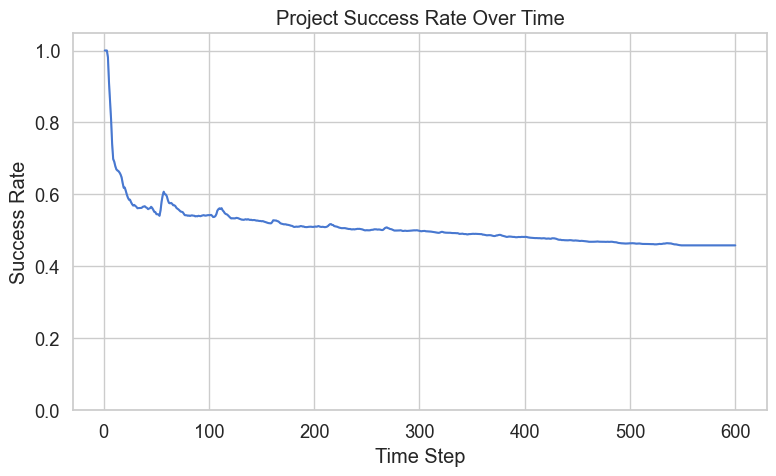

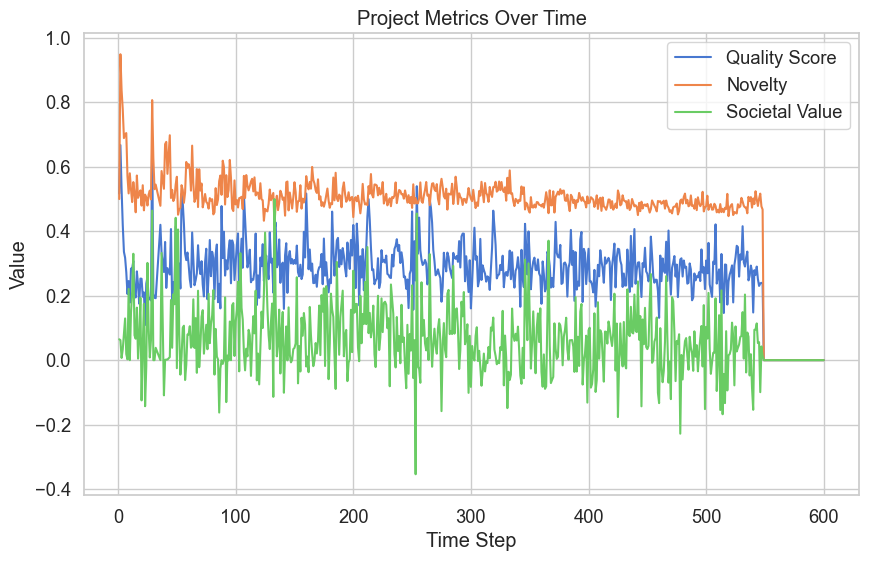

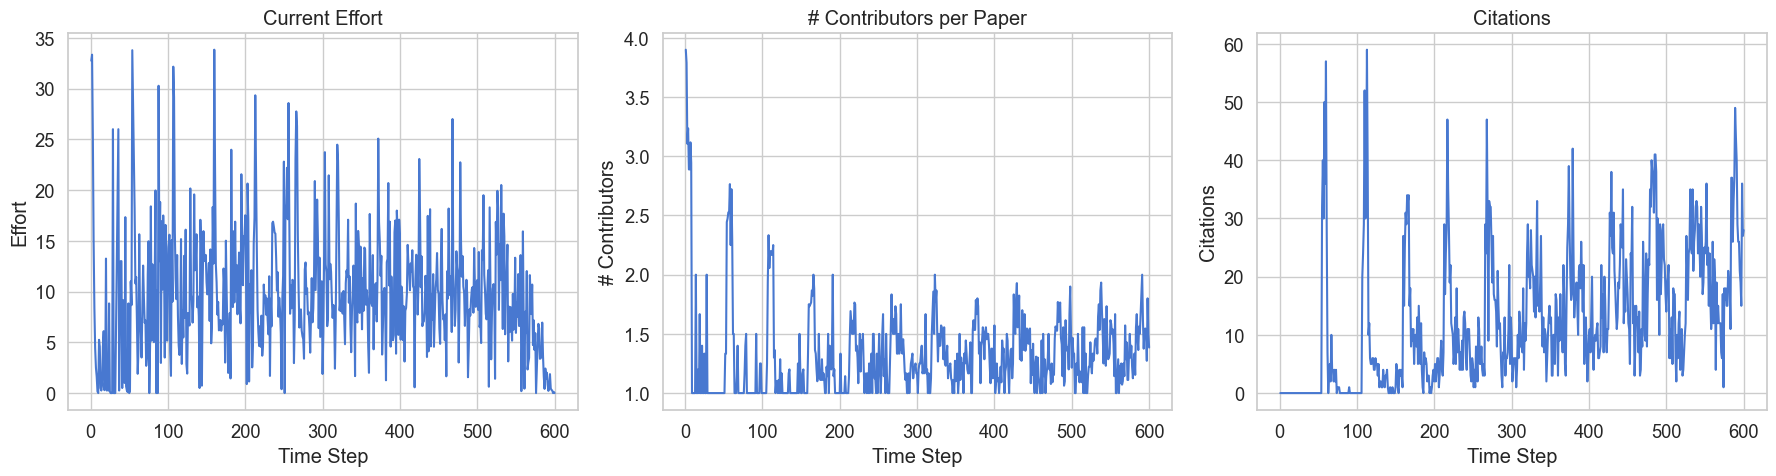

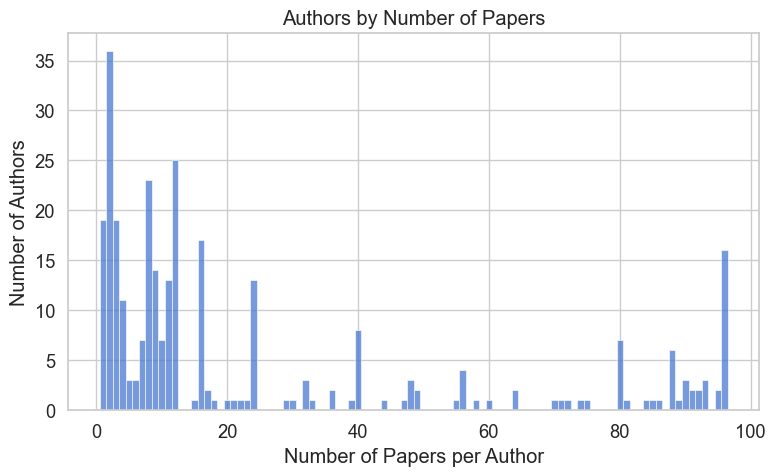

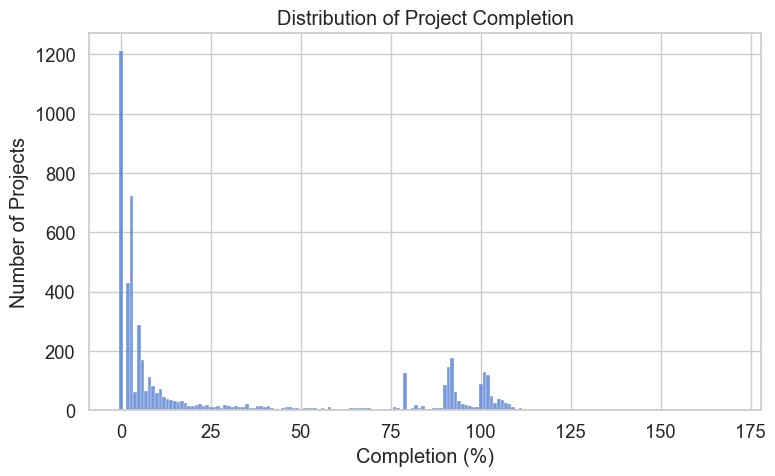

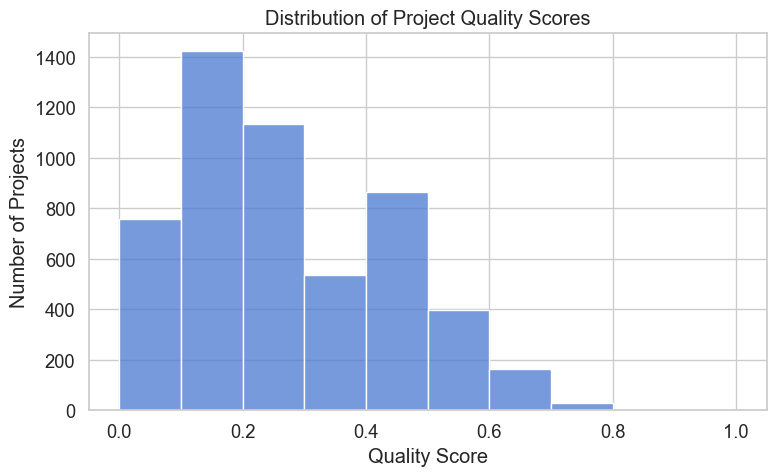

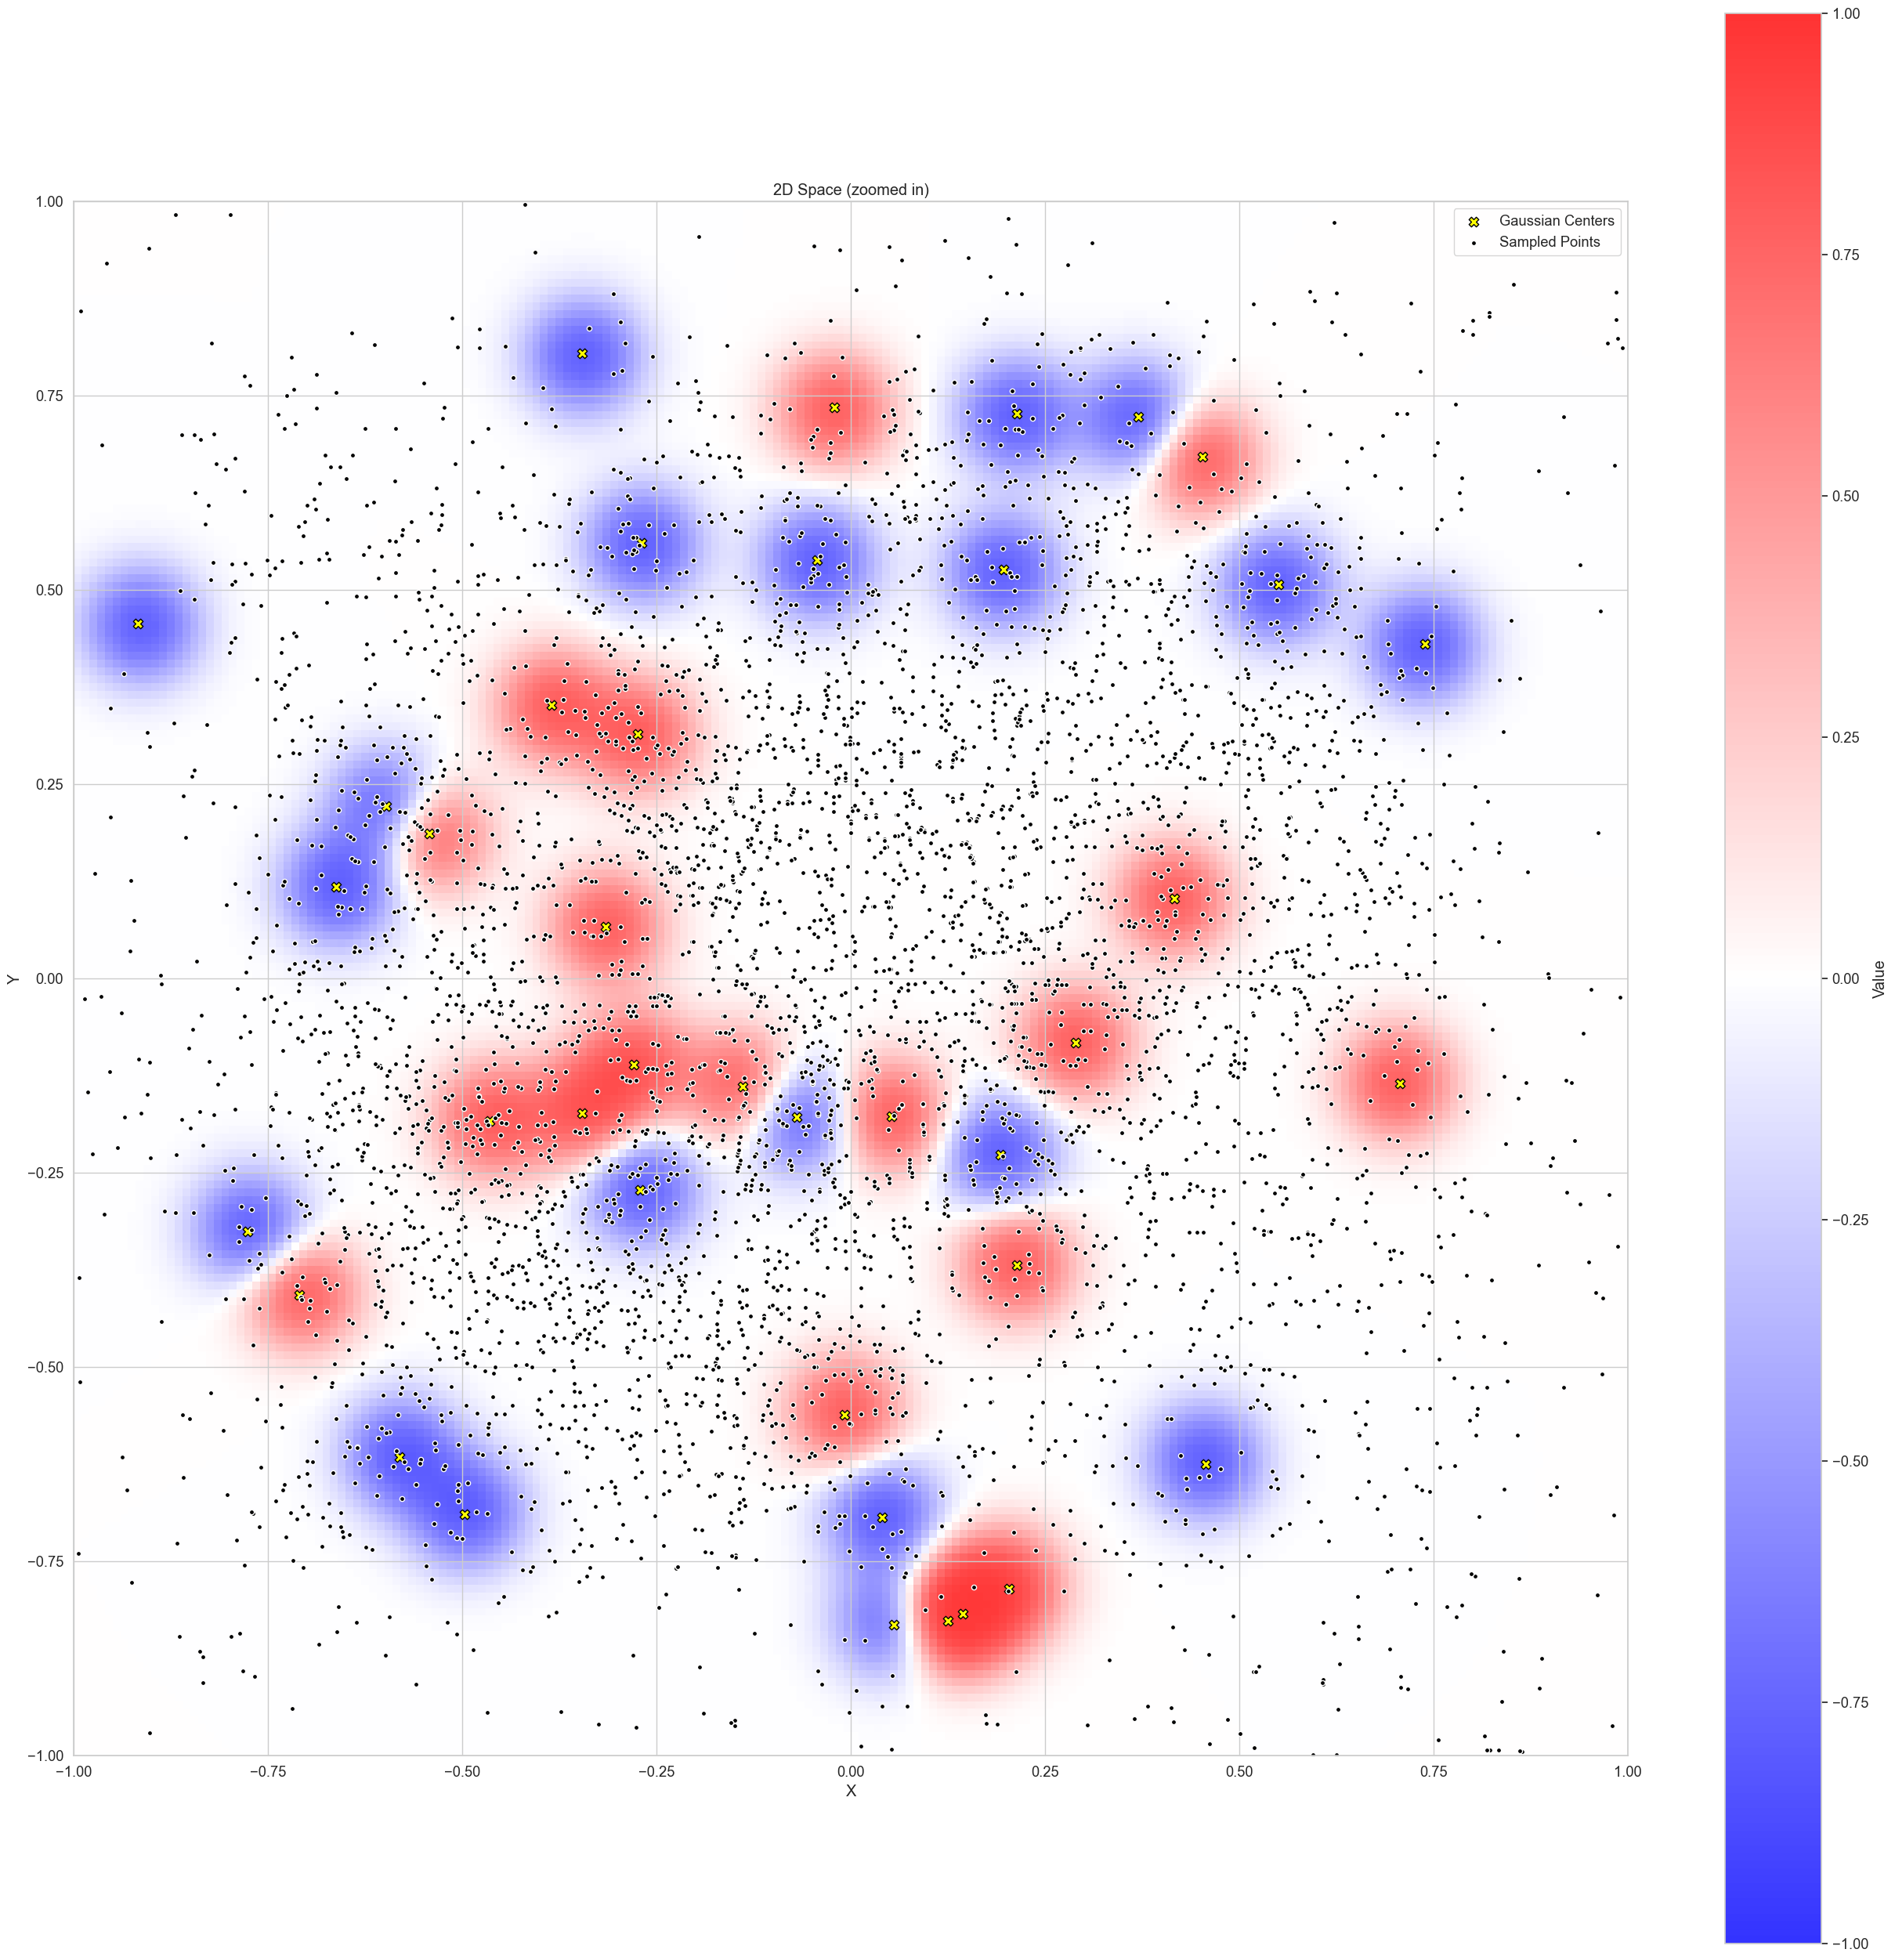

In [3]:
# Load projects list from JSON file
with open("../log/balanced_multiply_projects.json", "r") as f:
    balanced_projects = json.load(f)
with open("../log/balanced_multiply_actions.jsonl", "r") as f:
    balanced_actions = []
    for line in f.readlines():
        balanced_actions.append(json.loads(line))
visualize_policy_population_proportion(balanced_actions)
visualize_policy_population(balanced_actions)
plot_histograms(balanced_projects, "../log/balanced_multiply_area.pickle")


<Figure size 640x480 with 0 Axes>

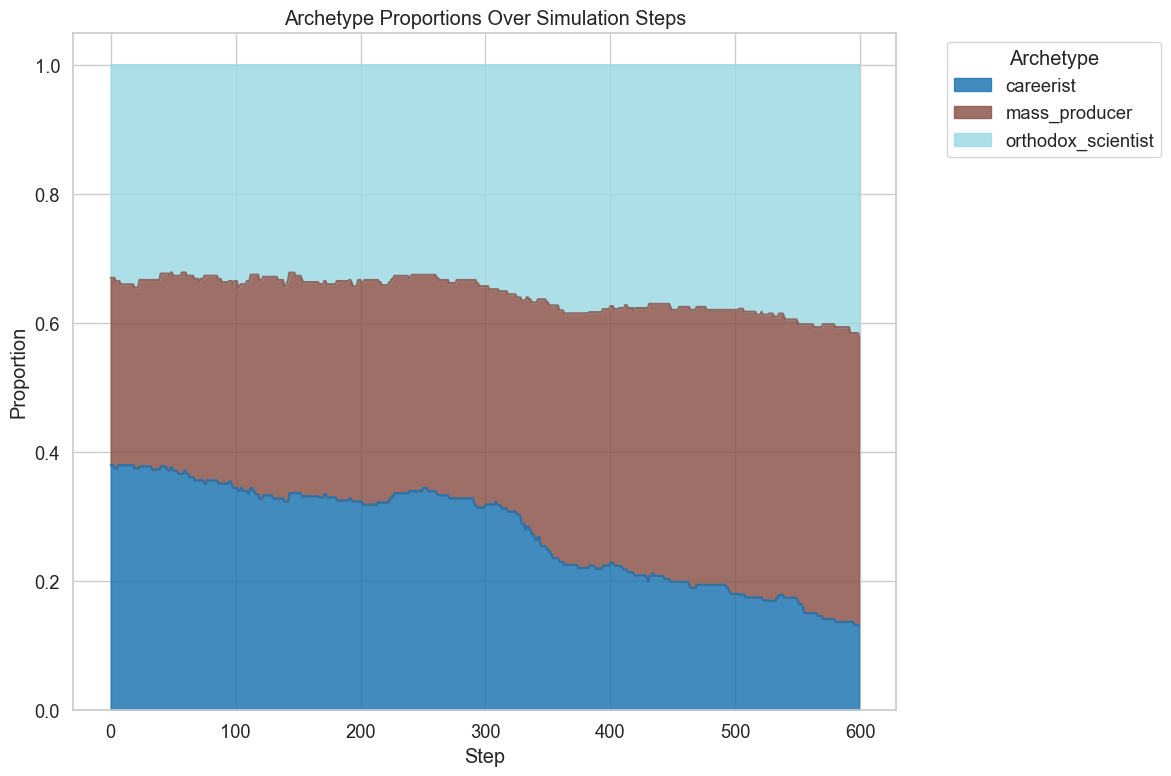

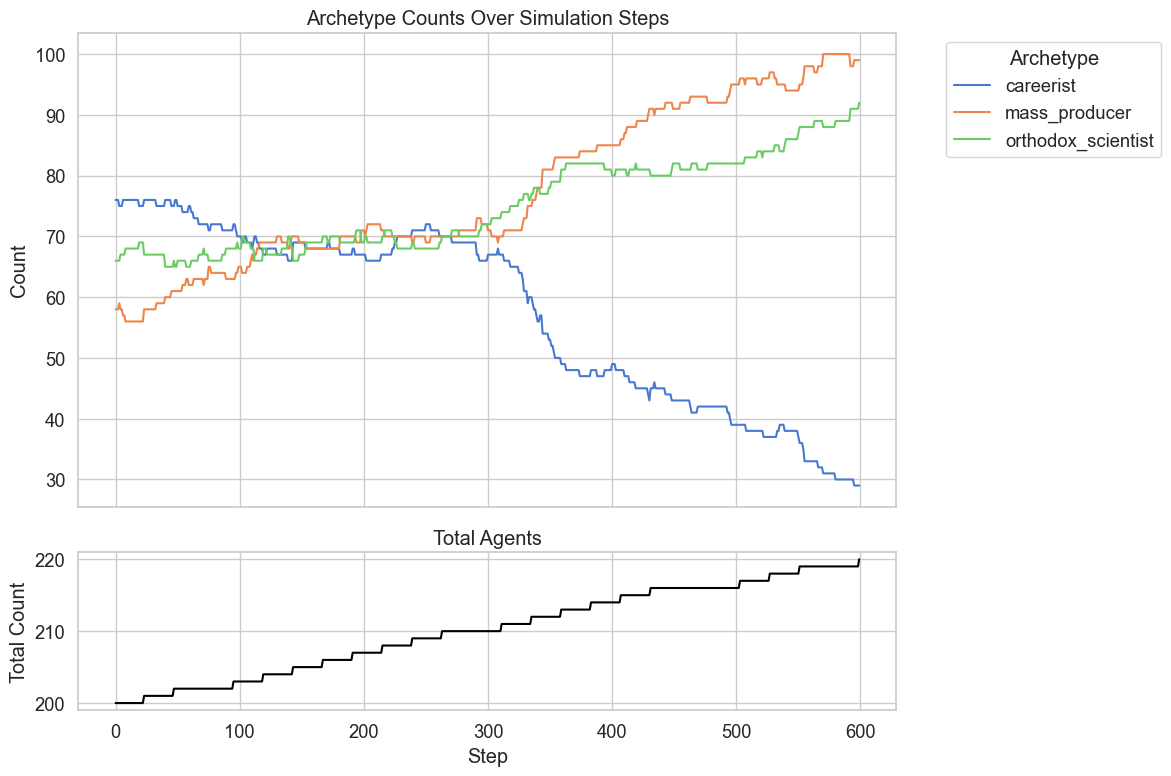

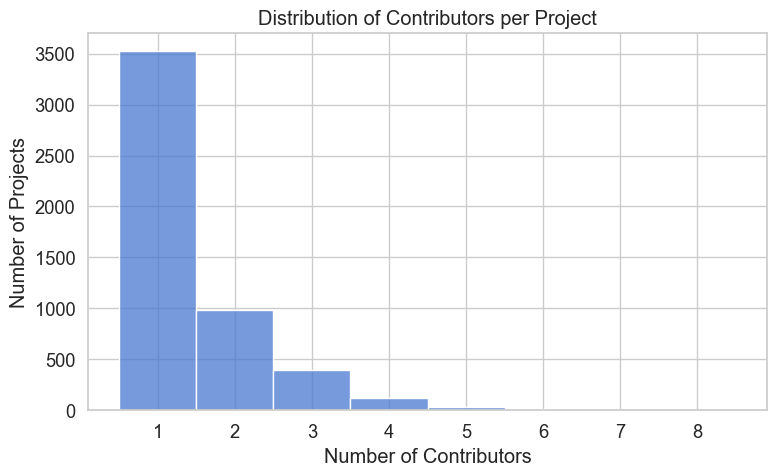

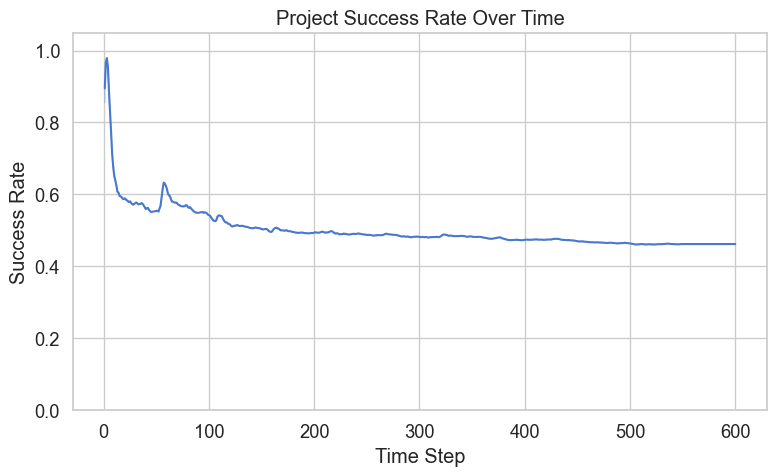

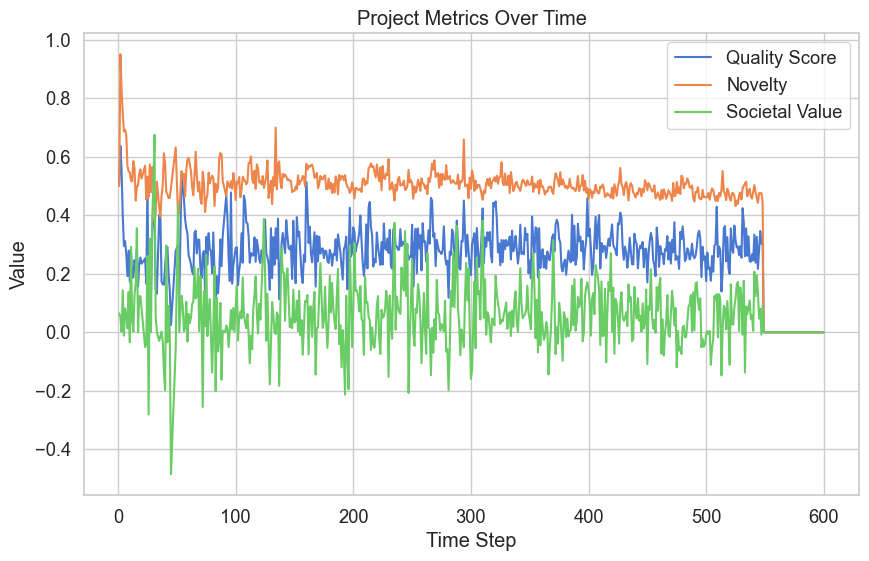

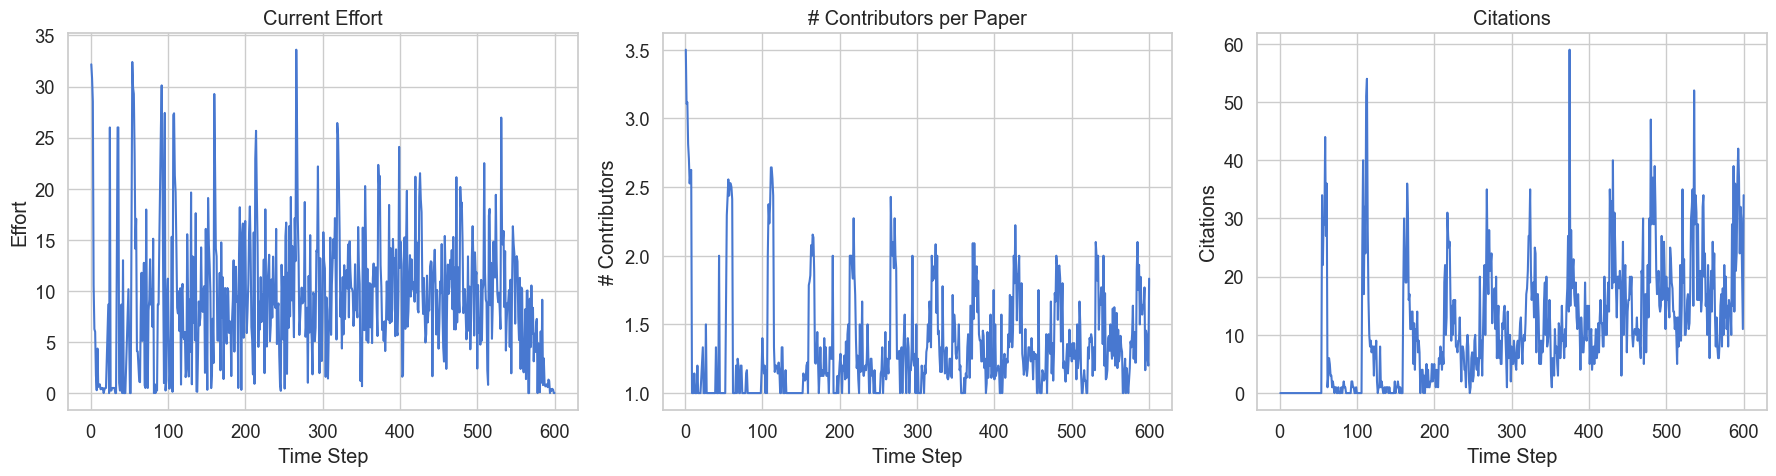

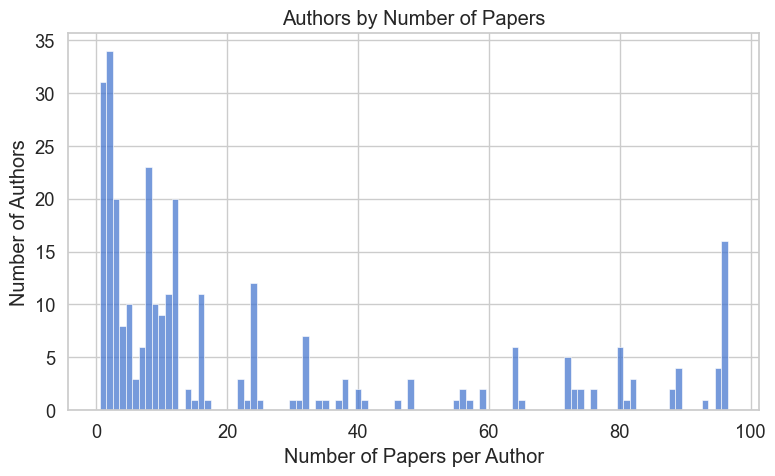

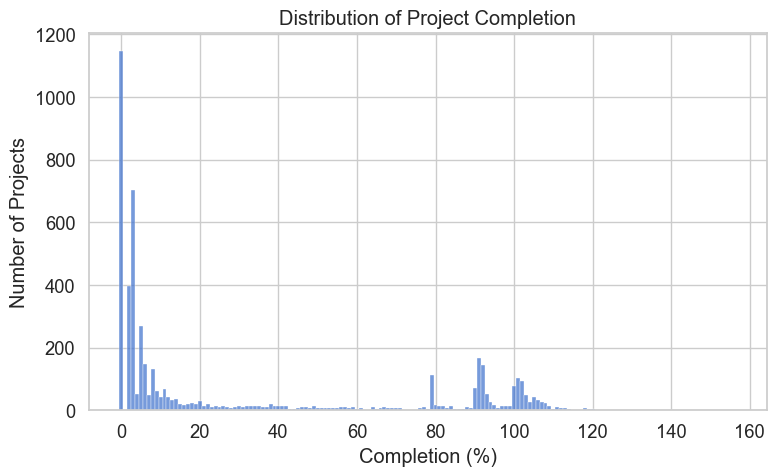

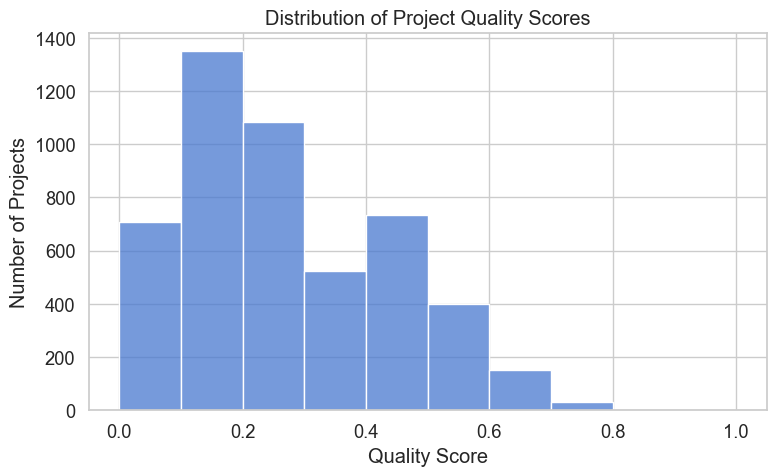

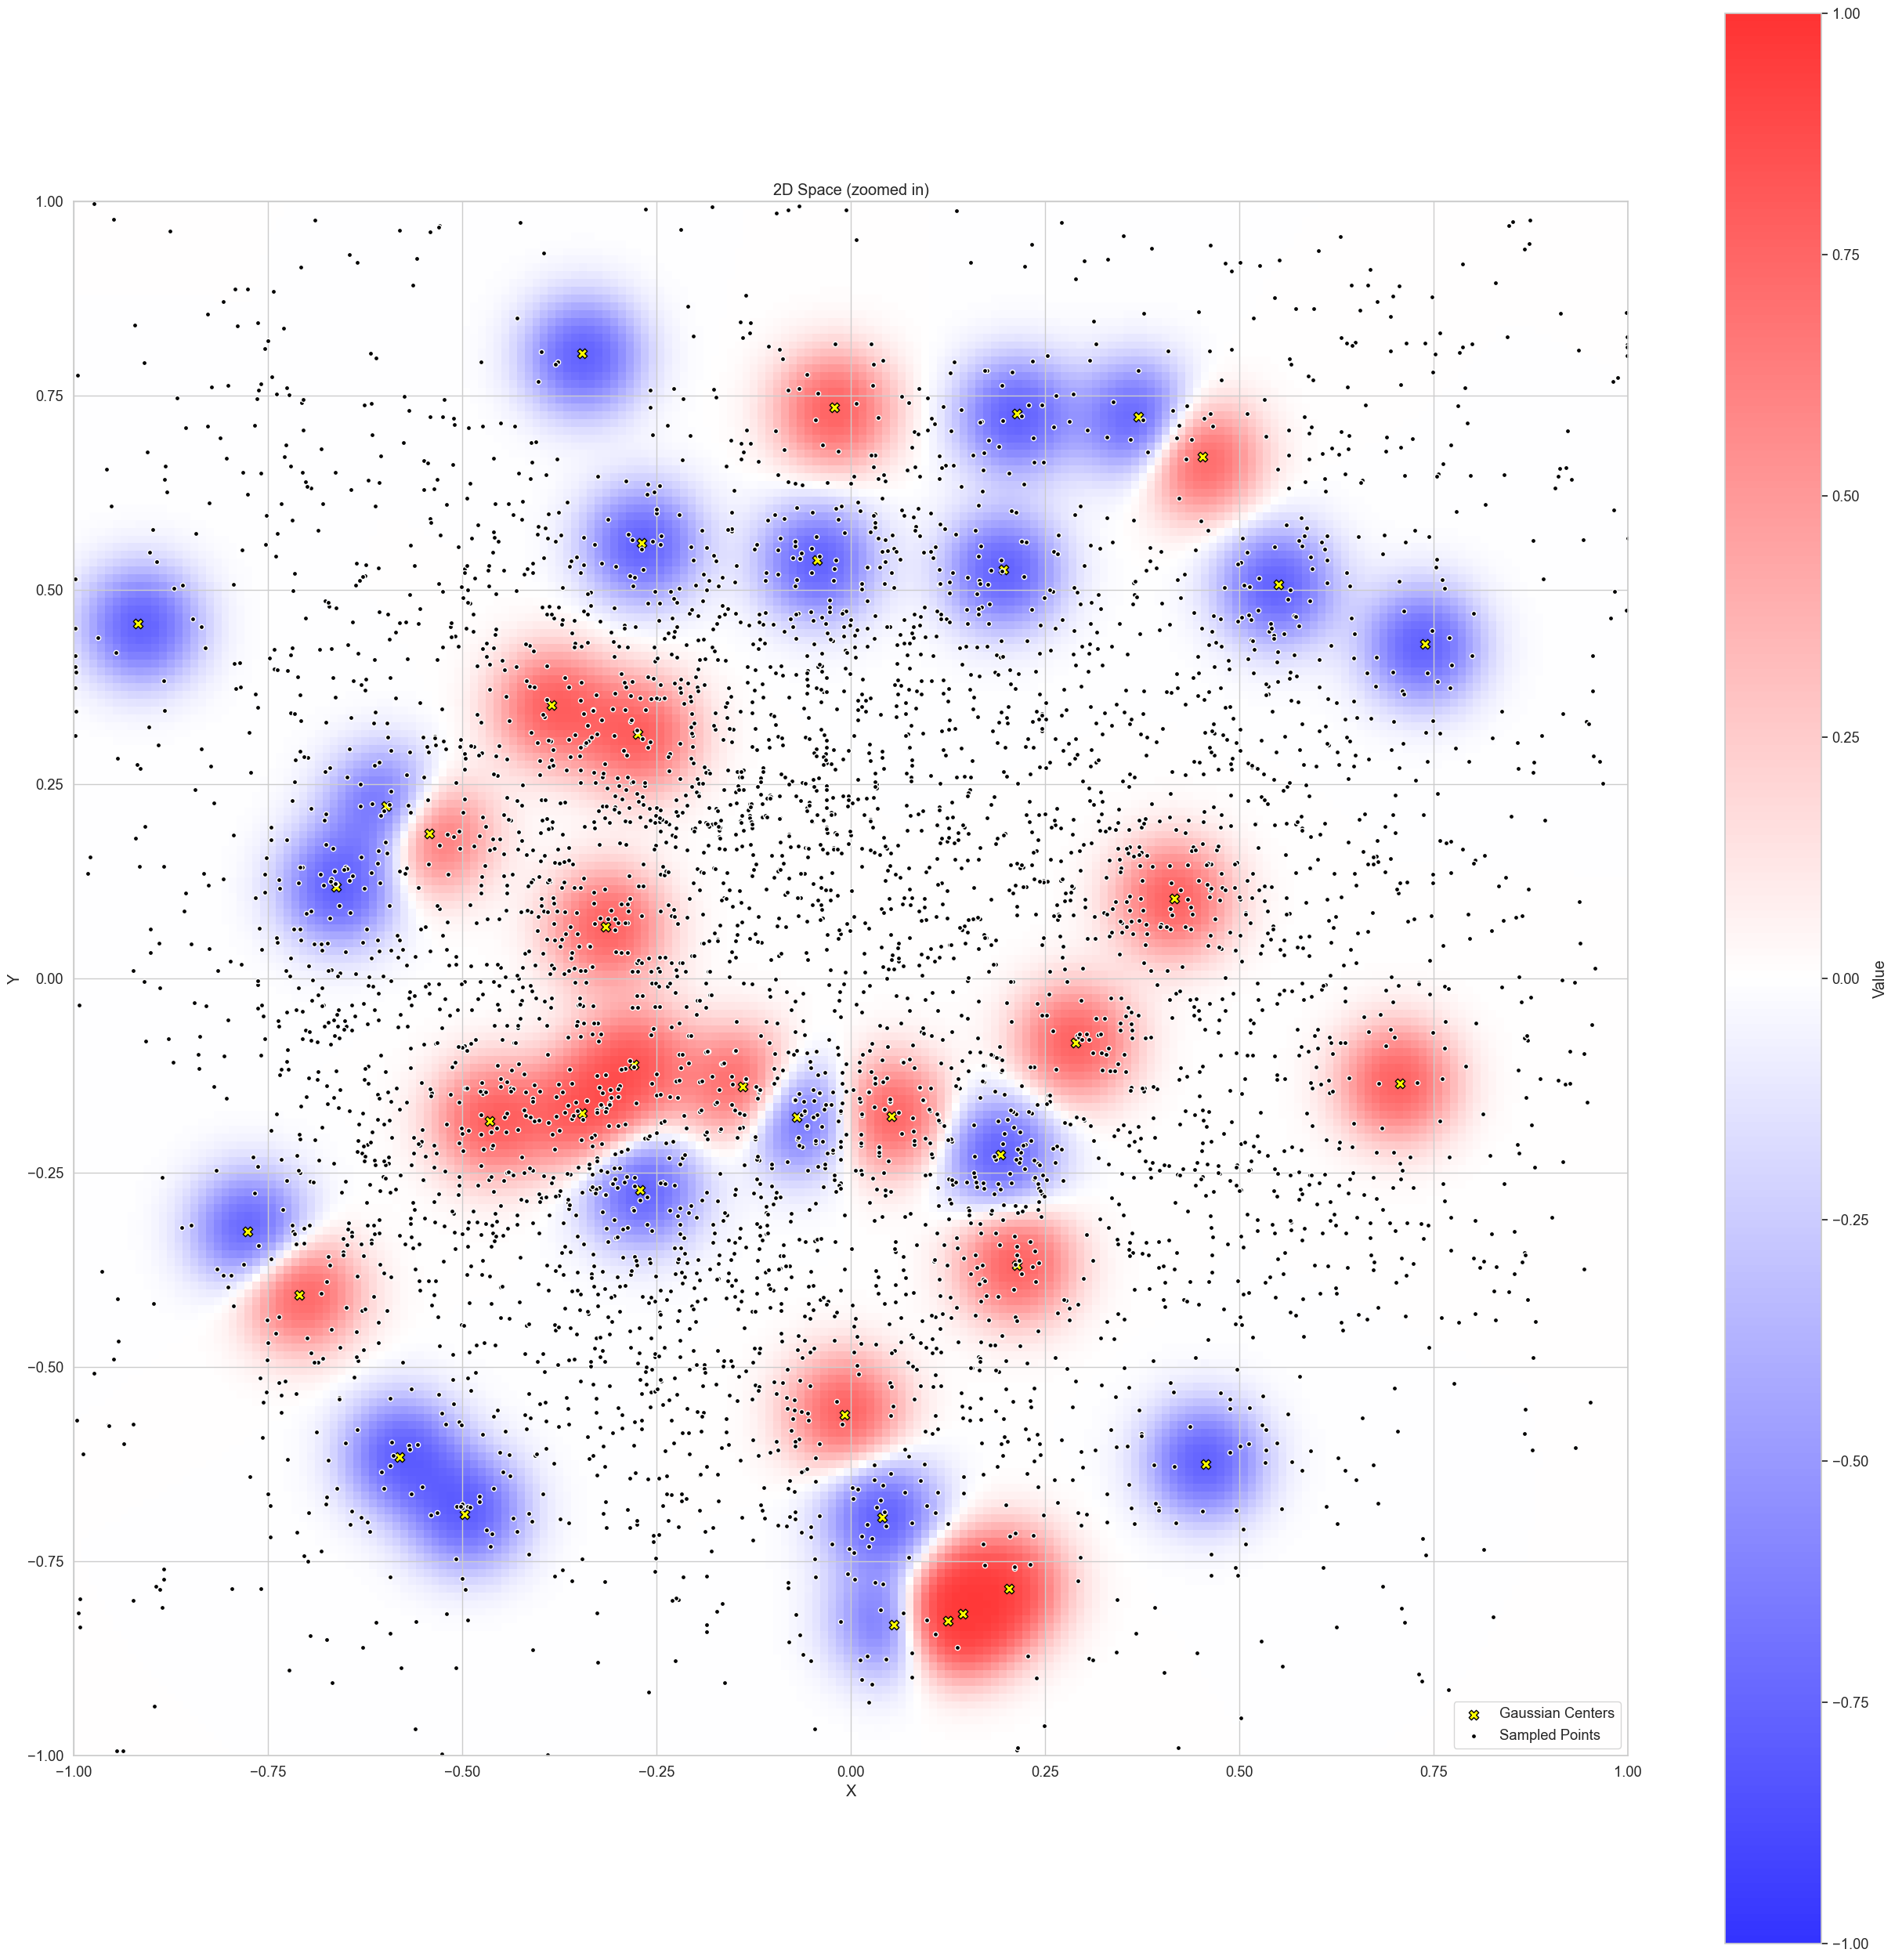

In [4]:
# Load projects list from JSON file
with open("../log/balanced_evenly_projects.json", "r") as f:
    balanced_evenly_projects = json.load(f)
with open("../log/balanced_evenly_actions.jsonl", "r") as f:
    balanced_evenly_actions = []
    for line in f.readlines():
        balanced_evenly_actions.append(json.loads(line))
visualize_policy_population_proportion(balanced_evenly_actions)
visualize_policy_population(balanced_evenly_actions)
plot_histograms(balanced_evenly_projects, "../log/balanced_evenly_area.pickle")

In [7]:
balanced_projects[0]

{'project_id': 'project_0-0-1',
 'required_effort': 33,
 'prestige': 0.3797258234975459,
 'time_window': 52.0,
 'peer_fit': [0.5, 0.5, 0.5, 0.5],
 'novelty': 0.19997481895532615,
 'current_effort': 33.0,
 'contributors': [0, 40, 100, 120],
 'start_time': 1,
 'finished': True,
 'final_reward': 0.5194108503744204,
 'kene': [0.6719507890596692, 0.33744818626372103],
 'citations': [],
 'cited_by': ['project_286-0-55',
  'project_286-0-55',
  'project_360-0-59',
  'project_989-0-153',
  'project_1054-0-162',
  'project_1164-0-169',
  'project_1437-0-213',
  'project_1652-0-229',
  'project_1709-0-237',
  'project_2145-0-292'],
 'generator_project_id': None,
 'validation_noise': 1.0283153942890082,
 'quality_score': 0.4999957840527159,
 'novelty_score': 0.5,
 'societal_value_score': -1.2647841852296747e-05,
 'effort_score': 1.0}

In [ ]:
# Load projects list from JSON file
with open("../log/policy_careerist_heavy_projects.json", "r") as f:
    careerist_heavy_projects = json.load(f)

In [ ]:
plot_histograms(careerist_heavy_projects, "../log/policy_careerist_heavy_area.pickle")

In [ ]:
# Load projects list from JSON file
with open("../log/policy_orthodox_heavy_projects.json", "r") as f:
    orthodox_heavy_projects = json.load(f)

In [ ]:
plot_histograms(orthodox_heavy_projects, "../log/policy_orthodox_heavy_area.pickle")

In [ ]:
# Load projects list from JSON file
with open("../log/debug_sim_projects.json", "r") as f:
   debug_projects = json.load(f)


In [ ]:
plot_histograms(debug_projects, "../log/debug_sim_actions.pickle")

In [ ]:
# Load observations list from JSON file
debug_obs = []
with open("../log/debug_sim_observations.jsonl", "r") as f:
    for line in f.readlines():
        debug_obs.append(json.loads(line.strip()))

In [ ]:
len(debug_obs)

2000

In [ ]:
len([o for o in debug_obs[0] if o is not None])

100

In [ ]:
debug_projects[0]

{'project_id': 'project_0-0-1',
 'required_effort': 9,
 'prestige': 0.6357000247046045,
 'time_window': 18.0,
 'peer_fit': [0.5],
 'novelty': 0.07366188122867724,
 'current_effort': 3.0,
 'contributors': [83],
 'start_time': 1,
 'finished': True,
 'final_reward': 0.6357000247046045,
 'kene': [-0.1648667394196213, 0.8356515056102948],
 'citations': [],
 'cited_by': ['project_1162-5-334', 'project_1162-5-334'],
 'generator_project_id': None,
 'validation_noise': 1.0640373313732217,
 'quality_score': 0.43386180003985036}

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 5, 1, 4, 2, 1, 4, 3, 1, 1, 3, 1, 2, 2, 3, 1, 3, 5, 3, 2, 1, 1, 4, 3, 1, 1, 4, 1, 1, 3, 3, 1, 2, 5, 1, 3, 2, 1, 4, 3, 4, 1, 1, 2, 3, 3, 1, 3, 4, 3, 2, 1, 1, 4, 3, 2, 1, 3, 2, 1, 2, 3, 3, 1, 1, 3, 4, 1, 4, 2, 2, 3, 2, 1, 3, 1, 1, 2, 4, 3, 1, 4, 4, 3, 2, 1, 3, 3, 2, 2, 1, 4, 3, 1, 2, 4, 1, 4, 2, 2, 2, 4, 2, 2, 1, 4, 3, 1, 1, 3, 4, 3, 2, 2, 1, 2, 3, 1, 2, 2, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

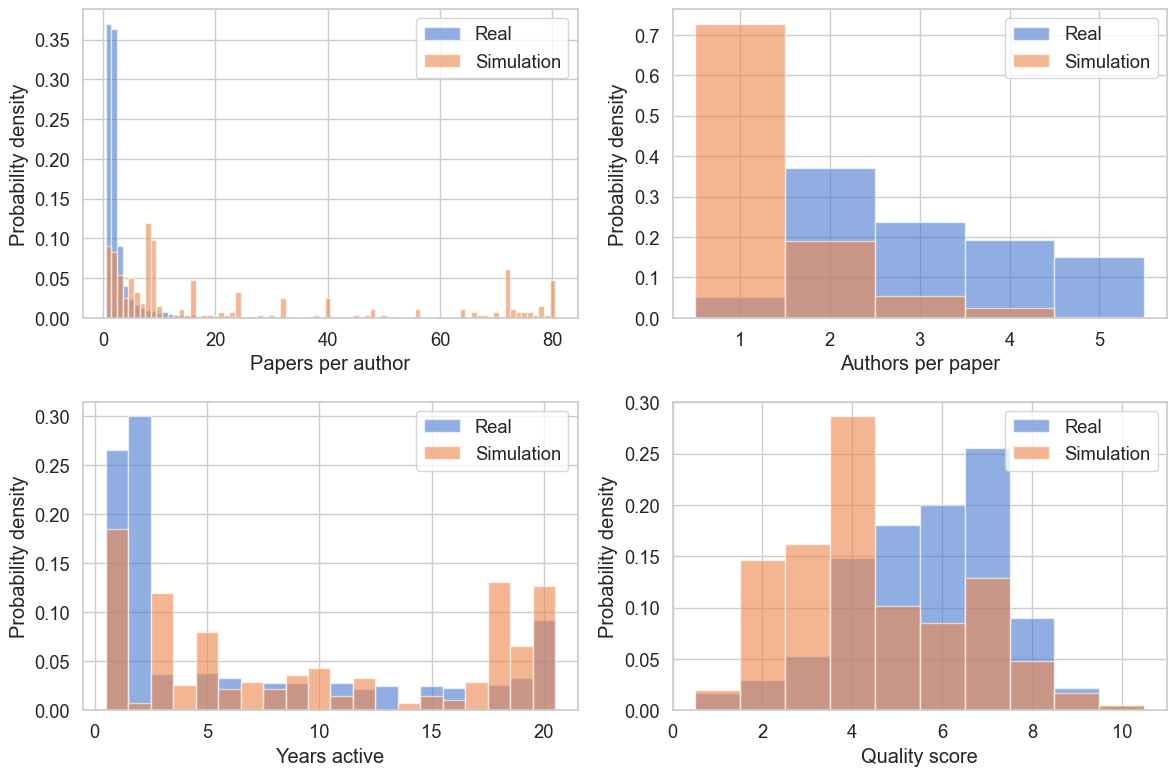

In [ ]:
from calibrate import build_normalized_hist, build_stats, plot_calibration_overlays
# Load real data
  # leave as-is

# Load sim data
with open("../log/balanced_projects.json", "r") as f:
    run_projects = json.load(f)

sim_data = build_stats(run_projects)
print(sim_data["authors_per_paper"])
sim_hists = {}
sim_centers = {}

counts, centers = build_normalized_hist(sim_data["papers_per_author"], int(max(sim_data["papers_per_author"])))
sim_hists["papers_per_author"], sim_centers["papers_per_author"] = counts, centers

counts, centers = build_normalized_hist(sim_data["authors_per_paper"], int(max(sim_data["authors_per_paper"])))
sim_hists["authors_per_paper"], sim_centers["authors_per_paper"] = counts, centers

counts, centers = build_normalized_hist(np.array(sim_data["lifespan"]) / 52, 20)
sim_hists["lifespan"], sim_centers["lifespan"] = counts, centers

counts, centers = build_normalized_hist(np.array(sim_data["quality"]) * 10, 10)
sim_hists["quality"], sim_centers["quality"] = counts, centers


real_data = {}
real_centers = {}
papers_per_author = np.load("../papers_per_author.npy")
counts, centers = build_normalized_hist(papers_per_author[papers_per_author < max(sim_data["papers_per_author"])], int(max(sim_data["papers_per_author"])))
real_data["papers_per_author"], real_centers["papers_per_author"] = counts, centers

authors_per_paper = np.load("../authors_per_paper.npy")
print(authors_per_paper[authors_per_paper < max(sim_data["authors_per_paper"])].tolist())
counts, centers = build_normalized_hist(authors_per_paper[authors_per_paper < max(sim_data["authors_per_paper"])], int(max(sim_data["authors_per_paper"])))
real_data["authors_per_paper"], real_centers["authors_per_paper"] = counts, centers

counts, centers = build_normalized_hist(np.load("../author_lifespan.npy"), 20)
real_data["lifespan"], real_centers["lifespan"] = counts, centers

counts, centers = build_normalized_hist(np.load("../quality_histogram.npy"), 10)
real_data["quality"], real_centers["quality"] = counts, centers

real_data["acceptance"] = np.load("../acceptance_histogram.npy")

# def plot_calibration_overlays(real_data, sim_data, outfile=None):
#     """
#     Plots overlayed line plots of real vs simulation histograms.
#     Both real_data and sim_data should contain normalized histograms
#     (same number of bins per metric).
#     """
#     metrics = [
#         ("papers_per_author", "Distribution of Papers per Author", "Papers per author"),
#         ("authors_per_paper", "Authors per Paper", "Authors per paper"),
#         ("lifespan", "Career Length", "Years active"),
#         ("quality", "Paper Quality", "Quality score"),
#     ]

#     fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#     for ax, (key, title, xlabel) in zip(axes.flatten(), metrics):
#         y_real = real_data[key]
#         y_sim = sim_data[key]
#         x = np.arange(len(y_real))  # bin indices as x-axis
#         ax.plot(x, y_real, label="Real", lw=2)
#         ax.plot(x, y_sim, label="Simulation", lw=2, linestyle="--")
#         ax.set_title(title)
#         ax.set_xlabel(xlabel)
#         ax.set_ylabel("Probability density")
#         ax.legend()

#     plt.tight_layout()
#     if outfile:
#         plt.savefig(outfile, dpi=300)
#     plt.show()

def plot_calibration_overlays(real_data, sim_data, outfile=None):
    """
    Plots overlayed histograms of real vs simulation data.
    Both real_data and sim_data should contain normalized histograms
    (same number of bins per metric).
    """
    metrics = [
        ("papers_per_author", "", "Papers per author (0.004)"),
        ("authors_per_paper", "", "Authors per paper (0.05)"),
        ("lifespan", "", "Years active (0.014)"),
        ("quality", "", "Quality score (0.02)"),
    ]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for ax, (key, _, xlabel) in zip(axes.flatten(), metrics):
        y_real = real_data[key]
        y_sim = sim_data[key]
        x = np.arange(len(y_real))+1  # bin indices as x-axis

        # Overlayed histograms (transparent bars)
        ax.bar(x, y_real, width=1.0, alpha=0.6, label="Real")
        ax.bar(x, y_sim, width=1.0, alpha=0.6, label="Simulation")

        # ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Probability density")
        ax.legend()

    plt.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
    plt.show()



# Example call
plot_calibration_overlays(real_data, sim_hists,# real_centers, sim_centers,
    outfile="calibration_overlay.png")